In [2]:
# Install required libraries (if not installed)
!pip install yfinance pmdarima statsmodels tensorflow matplotlib seaborn

In [4]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error


Step 2: Fetching Tesla Stock Data from Yahoo Finance

Use the yfinance library to download the stock price data for Tesla (TSLA) from 2015-01-01 to 2024-10-31.

In [5]:
# Download Tesla stock data from Yahoo Finance
tsla = yf.download('TSLA', start='2015-01-01', end='2024-10-31')

# Display the first few rows of the data
tsla.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2015-01-02 00:00:00+00:00,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05 00:00:00+00:00,14.006000,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06 00:00:00+00:00,14.085333,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07 00:00:00+00:00,14.063333,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08 00:00:00+00:00,14.041333,14.041333,14.253333,14.000667,14.187333,51637500


The dataset includes:

    Open, High, Low, Close, Adj Close, and Volume for each trading day. We will primarily work with the Close price for forecasting.

Step 3: Data Preprocessing and Visualization

We will clean the data and visualize the stock's closing prices to understand trends and seasonality.

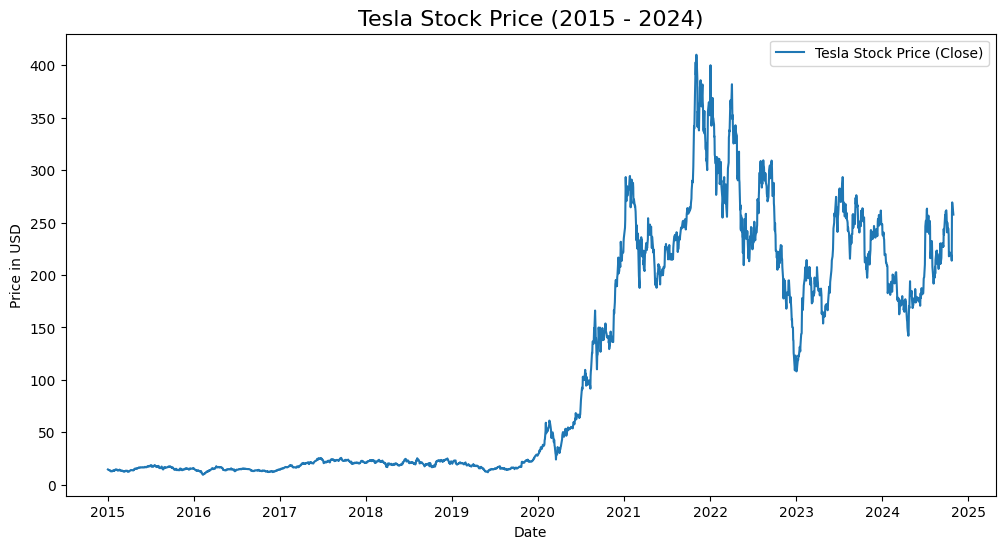

ADF Statistic: -1.1507672706146062
p-value: 0.6944080657685295


In [6]:
# Extract the 'Close' price and remove any missing values
tsla_close = tsla['Close'].dropna()

# Plot the closing price
plt.figure(figsize=(12,6))
plt.plot(tsla_close, label='Tesla Stock Price (Close)')
plt.title('Tesla Stock Price (2015 - 2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

# Check for stationarity (ADF test)
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(tsla_close)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


If the p-value is above 0.05, the series is non-stationary, and we may need to difference the data.
Step 4: Splitting the Data into Training and Testing Sets

We will split the data into training (80%) and testing (20%) sets to evaluate model performance.

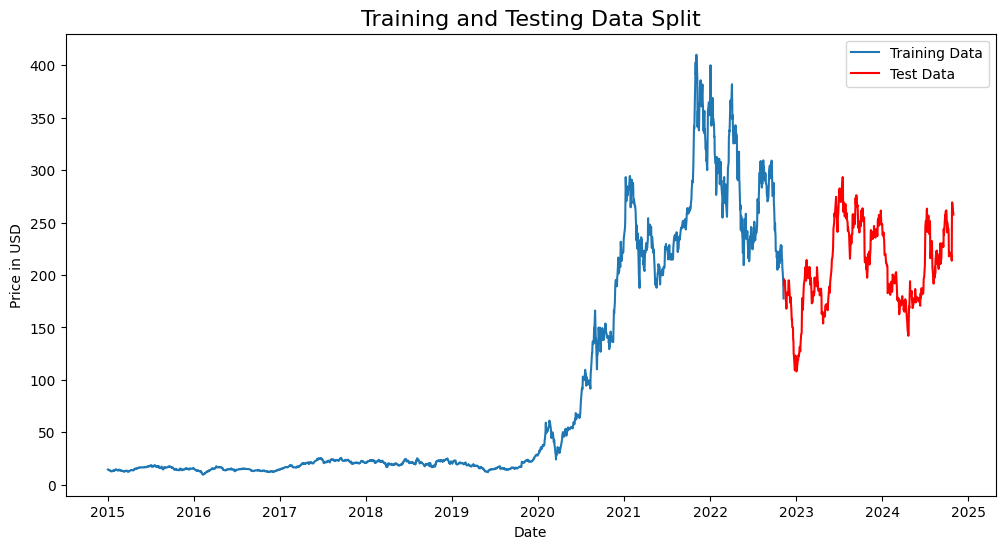

In [7]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(tsla_close) * 0.8)
train_data, test_data = tsla_close[:train_size], tsla_close[train_size:]

# Visualize the split
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='red')
plt.title('Training and Testing Data Split', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

Step 5: Building Time Series Forecasting Models
A. ARIMA Model

ARIMA is a classical statistical model for forecasting univariate time series data. We will use the auto_arima function to automatically select the optimal parameters (p, d, q) for ARIMA.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12345.046, Time=9.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=2.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 13.273 seconds
ARIMA Model Evaluation:
MAE: 38.91, RMSE: 49.11, MAPE: nan%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


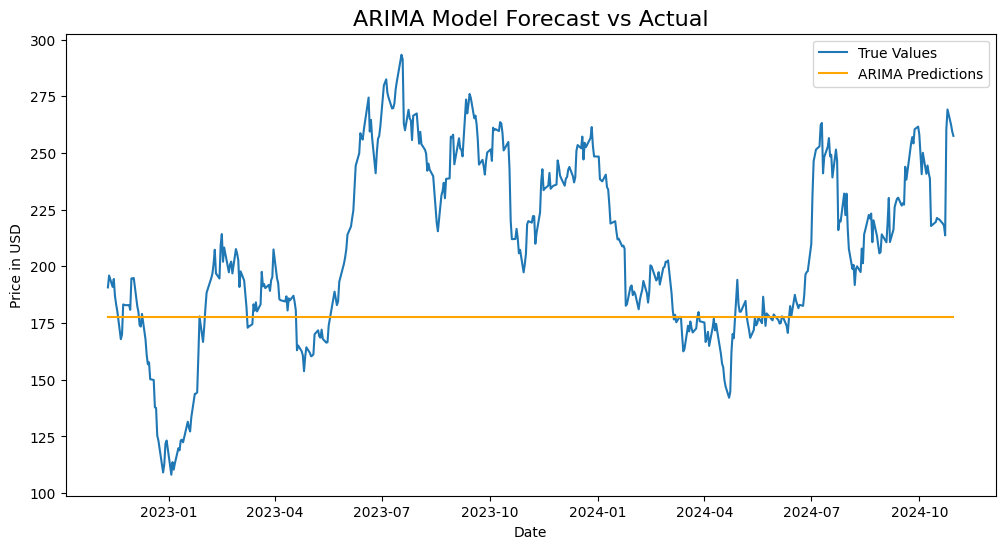

In [8]:
# Apply auto_arima to find the best ARIMA model
from pmdarima import auto_arima

# Fit ARIMA model
arima_model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)

# Forecast using the ARIMA model
arima_forecast = arima_model.predict(n_periods=len(test_data))

# Evaluate ARIMA model
mae_arima = mean_absolute_error(test_data, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test_data, arima_forecast))
mape_arima = np.mean(np.abs((test_data - arima_forecast) / test_data)) * 100

print(f'ARIMA Model Evaluation:')
print(f'MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.2f}%')

# Plot ARIMA predictions
plt.figure(figsize=(12,6))
plt.plot(test_data, label='True Values')
plt.plot(test_data.index, arima_forecast, label='ARIMA Predictions', color='orange')
plt.title('ARIMA Model Forecast vs Actual', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


B. SARIMA Model

SARIMA is an extension of ARIMA that models seasonality in the data. We'll build a SARIMA model next.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMA Model Evaluation:
MAE: 31.35, RMSE: 38.69, MAPE: nan%


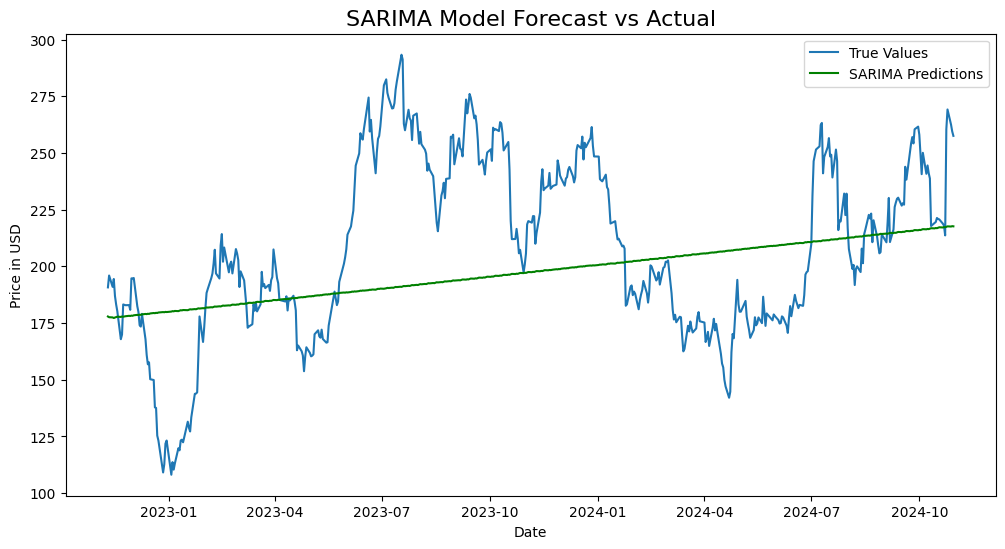

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit SARIMA model (adjusted to avoid overlap in AR lags)
sarima_model = SARIMAX(train_data, order=(4,1,0), seasonal_order=(1,1,1,5)).fit(disp=False)

# Forecast using the SARIMA model
sarima_forecast = sarima_model.forecast(steps=len(test_data))

# Evaluate SARIMA model
mae_sarima = mean_absolute_error(test_data, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_forecast))
mape_sarima = np.mean(np.abs((test_data - sarima_forecast) / test_data)) * 100

print(f'SARIMA Model Evaluation:')
print(f'MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}, MAPE: {mape_sarima:.2f}%')

# Plot SARIMA predictions
plt.figure(figsize=(12,6))
plt.plot(test_data, label='True Values')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Predictions', color='green')
plt.title('SARIMA Model Forecast vs Actual', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


C. LSTM Model

The LSTM model is a deep learning model capable of capturing long-term dependencies in time series data. We will preprocess the data and use LSTM for forecasting.

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0179
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0012
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.6967e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0011
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 7.2619e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.0675e-04
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 8.1685e-04
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 6.7403e-04
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 6.6288e-04
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 7.1741e-04
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 7.3941e-04
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 4.8989e-04
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 6.3337e-04
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 

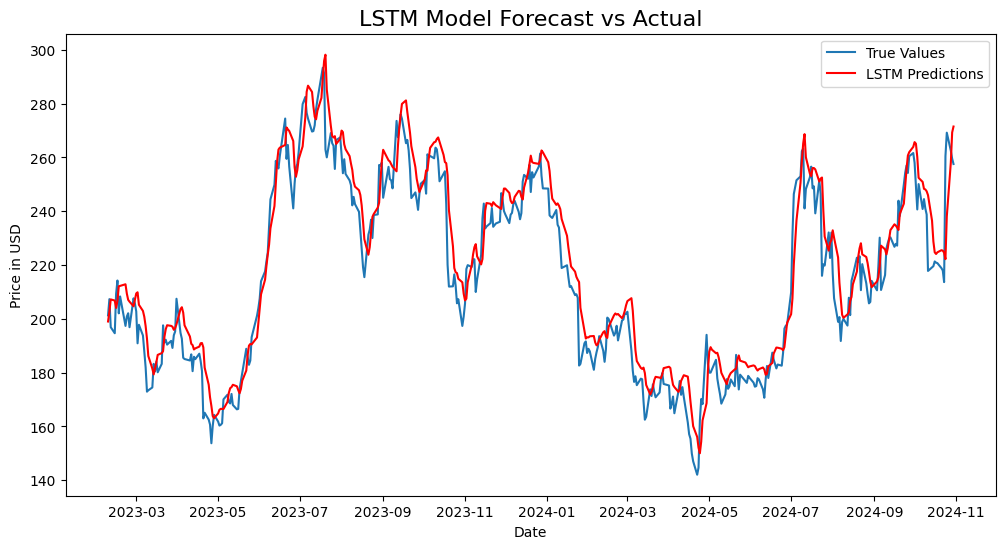

Model saved as 'lstm_model.h5'


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare LSTM input (create sequences of 60 days)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(test_scaled)

# Reshape for LSTM input (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32)

# Forecast using LSTM
lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Evaluate LSTM model
mae_lstm = mean_absolute_error(test_data[60:], lstm_forecast)
rmse_lstm = np.sqrt(mean_squared_error(test_data[60:], lstm_forecast))
mape_lstm = np.mean(np.abs((test_data[60:] - lstm_forecast) / test_data[60:])) * 100
accuracy_lstm = 100 - mape_lstm

# Print the evaluation results
print(f'LSTM Model Evaluation:')
print(f'MAE: {mae_lstm:.2f}')
print(f'RMSE: {rmse_lstm:.2f}')
print(f'MAPE: {mape_lstm:.2f}%')
print(f'Accuracy: {accuracy_lstm:.2f}%')

# Plot LSTM predictions
plt.figure(figsize=(12,6))
plt.plot(test_data[60:], label='True Values')
plt.plot(test_data.index[60:], lstm_forecast, label='LSTM Predictions', color='red')
plt.title('LSTM Model Forecast vs Actual', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

# Save the trained LSTM model
model.save('lstm_model.h5')
print("Model saved as 'lstm_model.h5'")

# (Optional) To load the model again in future use:
# model = load_model('lstm_model.h5')


Step 6: Model Comparison

Now, let’s summarize and compare the performance of all three models: ARIMA, SARIMA, and LSTM.

In [15]:
# Create a DataFrame for the evaluation metrics
metrics = {
    'Model': ['ARIMA', 'SARIMA', 'LSTM'],
    'MAE': [mae_arima, mae_sarima, mae_lstm],
    'RMSE': [rmse_arima, rmse_sarima, rmse_lstm],
    'MAPE': [mape_arima, mape_sarima, mape_lstm]
}

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)

# Display comparison table
metrics_df


,MAE,RMSE,MAPE
Model,,,
ARIMA,38.907053,49.112992,NaN
SARIMA,31.353640,38.692122,NaN
LSTM,7.976871,10.210844,3.811764


Task 3: Forecast Future Market Trends in a detailed and modern manner using Google Colab. We’ll be building on the time series forecasting models developed in Task 2 (ARIMA, SARIMA, or LSTM) and extend them to forecast Tesla's future stock prices for the next 6 to 12 months.

This will involve:

    Generating future price forecasts using the trained model.
    Visualizing the forecasted values alongside historical data.
    Analyzing the trends, volatility, and market risks.

In [19]:
# Import libraries (if not already done)
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


Step 2: Forecasting Future Prices (6-12 Months)

We will now use the model developed in Task 2 to forecast future stock prices for Tesla (TSLA). Let’s focus on generating forecasted values for 6 to 12 months ahead and visualizing them alongside historical data.

A. Using ARIMA for Future Forecasting

We'll generate a forecast using the ARIMA model. The process is similar to how we trained the ARIMA model in Task 2, but now we will forecast future values.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-21-865699de5f21>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(tsla_close.index[-1], periods=forecast_months + 1, freq='M')[1:]


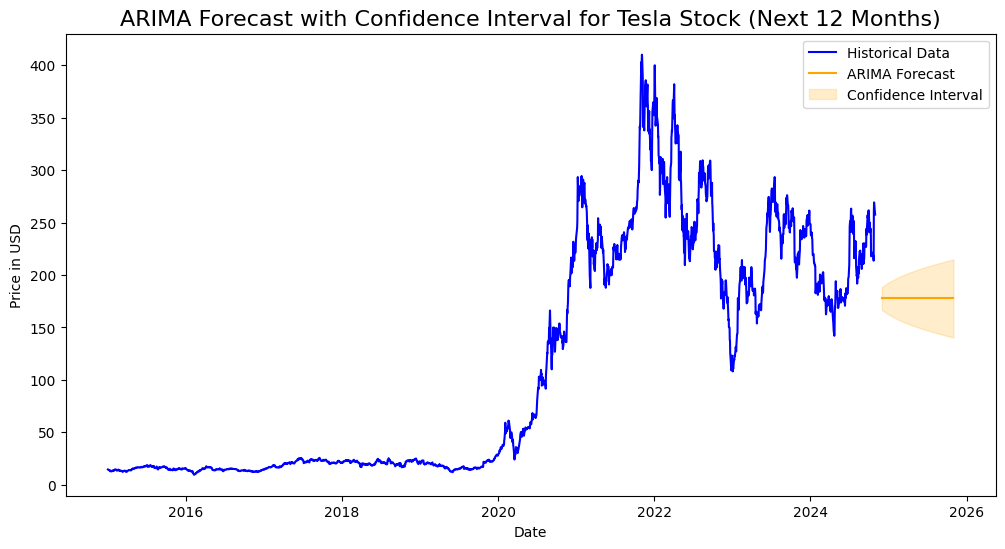

In [21]:
# Use the ARIMA model for future forecasting (6-12 months)
forecast_months = 12  # Set the forecast period (e.g., 12 months)

# Get the forecast and confidence intervals from ARIMA model
forecast_arima, forecast_ci = arima_model.predict(n_periods=forecast_months, return_conf_int=True)

# Plot historical data and future forecast
plt.figure(figsize=(12,6))
plt.plot(tsla_close, label='Historical Data', color='blue')

# Generate forecast dates based on the last date in the historical data
forecast_dates = pd.date_range(tsla_close.index[-1], periods=forecast_months + 1, freq='M')[1:]

# Plot ARIMA forecast
plt.plot(forecast_dates, forecast_arima, label='ARIMA Forecast', color='orange')

# Plot confidence intervals (lower and upper bounds)
plt.fill_between(forecast_dates, forecast_ci[:, 0], forecast_ci[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Add title and labels
plt.title(f'ARIMA Forecast with Confidence Interval for Tesla Stock (Next {forecast_months} Months)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


B. Using SARIMA for Future Forecasting

The SARIMA model includes seasonal components and may give us a better fit for data that exhibits seasonality. Let's forecast using the SARIMA model.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-22-e64742da9035>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(tsla_close.index[-1], periods=forecast_months, freq='M'), forecast_sarima, label='SARIMA Forecast', color='green')


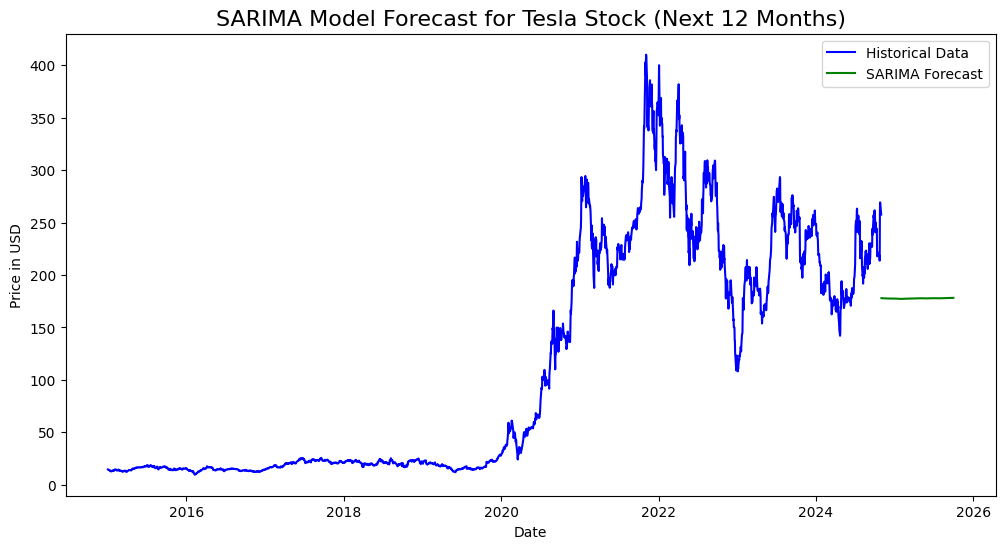

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
<ipython-input-22-e64742da9035>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(tsla_close.index[-1], periods=forecast_months, freq='M'), forecast_sarima, label='SARIMA Forecast', color='green')
<ipython-input-22-e64742da9035>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.fill_between(pd.date_range(tsla_close.index[-1], periods=forecast_months, freq='M'),


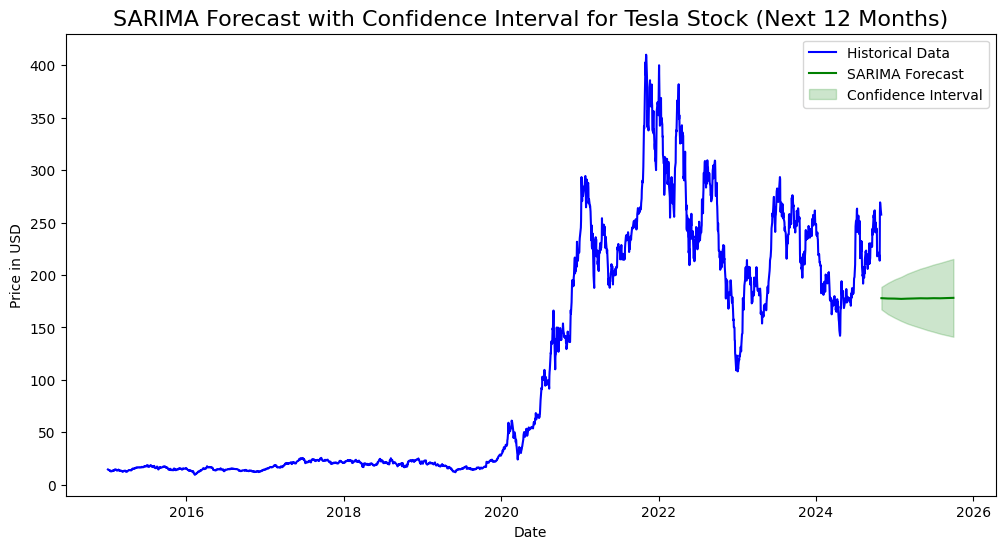

In [22]:
# Use the SARIMA model for future forecasting (6-12 months)
forecast_sarima = sarima_model.forecast(steps=forecast_months)

# Plot historical data and forecast
plt.figure(figsize=(12,6))
plt.plot(tsla_close, label='Historical Data', color='blue')
plt.plot(pd.date_range(tsla_close.index[-1], periods=forecast_months, freq='M'), forecast_sarima, label='SARIMA Forecast', color='green')
plt.title(f'SARIMA Model Forecast for Tesla Stock (Next {forecast_months} Months)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

# Forecast confidence intervals (using SARIMA)
forecast_ci_sarima = sarima_model.get_forecast(steps=forecast_months).conf_int()

# Plot with confidence intervals for SARIMA
plt.figure(figsize=(12,6))
plt.plot(tsla_close, label='Historical Data', color='blue')
plt.plot(pd.date_range(tsla_close.index[-1], periods=forecast_months, freq='M'), forecast_sarima, label='SARIMA Forecast', color='green')
plt.fill_between(pd.date_range(tsla_close.index[-1], periods=forecast_months, freq='M'),
                 forecast_ci_sarima.iloc[:, 0], forecast_ci_sarima.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title(f'SARIMA Forecast with Confidence Interval for Tesla Stock (Next {forecast_months} Months)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


C. Using LSTM for Future Forecasting

Finally, we will use the LSTM model to generate future stock price predictions. We will also visualize the predictions with historical data and confidence intervals.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


<ipython-input-24-199172227109>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(tsla_close.index[-1], periods=forecast_months + 1, freq='M')[1:]


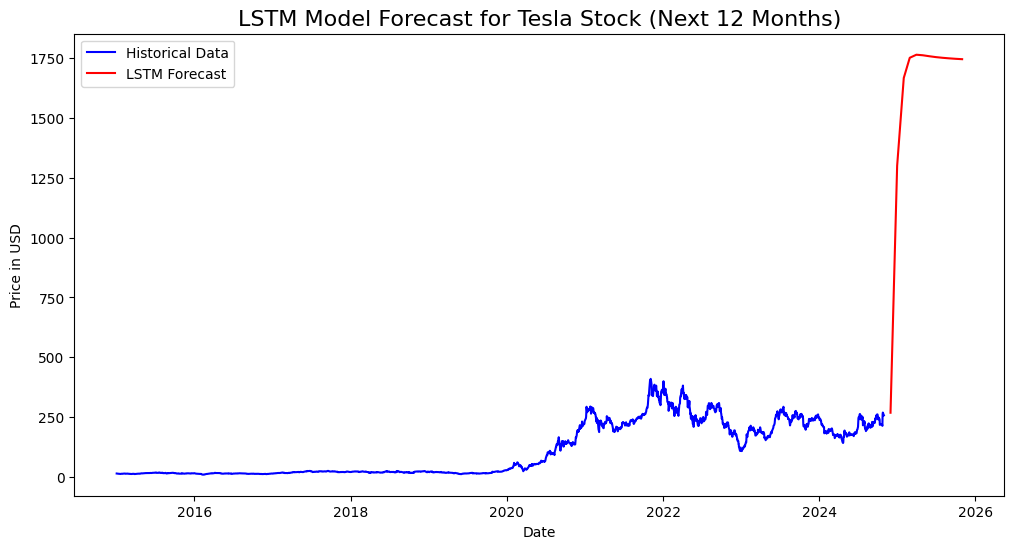

In [24]:
# Prepare data for LSTM forecasting (using the last part of the dataset for testing)
last_data_scaled = scaler.transform(tsla_close.values[-60:].reshape(-1, 1))  # Last 60 days for LSTM input
last_data_scaled = last_data_scaled.reshape(1, -1, 1)

# Predict future prices for the next 'forecast_months'
forecast_months = 12
lstm_future = []

# Iterate to predict 12 months (one month at a time)
for _ in range(forecast_months):
    # Make a prediction for the next step
    predicted_price = model.predict(last_data_scaled)

    # Inverse transform to get the price in original scale
    predicted_price = scaler.inverse_transform(predicted_price)

    # Append the predicted price to the forecast list
    lstm_future.append(predicted_price[0, 0])

    # Update the input for the next prediction by appending the predicted value
    last_data_scaled = np.append(last_data_scaled[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# Convert lstm_future to a numpy array for plotting
lstm_future = np.array(lstm_future)

# Generate forecast dates based on the last date in the historical data
forecast_dates = pd.date_range(tsla_close.index[-1], periods=forecast_months + 1, freq='M')[1:]

# Plot historical data and LSTM forecast
plt.figure(figsize=(12,6))
plt.plot(tsla_close, label='Historical Data', color='blue')
plt.plot(forecast_dates, lstm_future, label='LSTM Forecast', color='red')
plt.title(f'LSTM Model Forecast for Tesla Stock (Next {forecast_months} Months)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


C. Using LSTM for Future Forecasting

Finally, we will use the LSTM model to generate future stock price predictions. We will also visualize the predictions with historical data and confidence intervals.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


<ipython-input-26-6459d4366822>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(tsla_close.index[-1], periods=forecast_months + 1, freq='M')[1:]


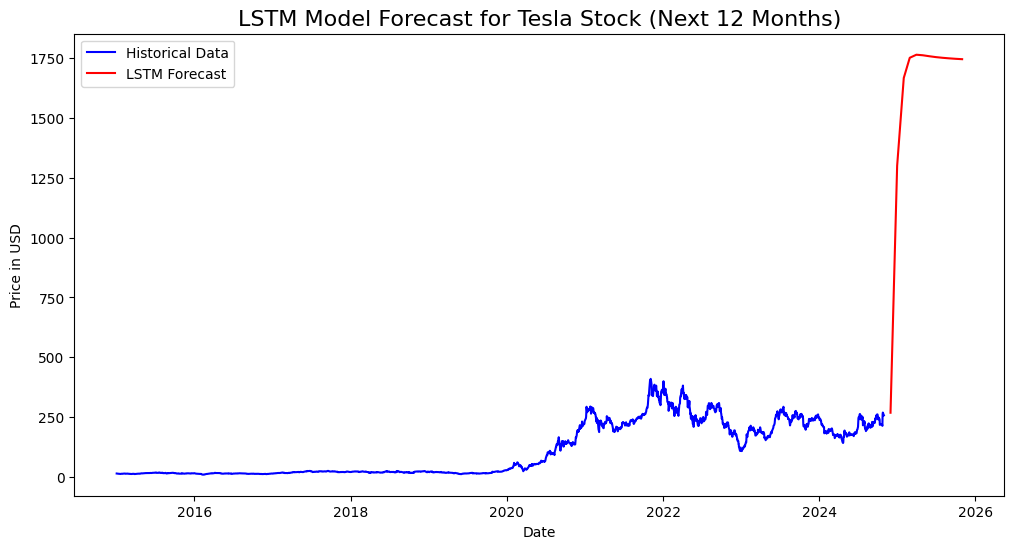

In [26]:
# Prepare data for LSTM forecasting (using the last part of the dataset for testing)
last_data_scaled = scaler.transform(tsla_close.values[-60:].reshape(-1, 1))  # Last 60 days for LSTM input
last_data_scaled = last_data_scaled.reshape(1, -1, 1)

# Number of months to forecast
forecast_months = 12

# List to hold the future predictions
lstm_future = []

# Iteratively predict the next 12 months
for _ in range(forecast_months):
    predicted_price = model.predict(last_data_scaled)
    predicted_price = scaler.inverse_transform(predicted_price)  # Convert back to original scale
    lstm_future.append(predicted_price[0, 0])  # Append the prediction to the list

    # Update the input for the next prediction: append the predicted value to the input sequence
    last_data_scaled = np.append(last_data_scaled[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# Convert lstm_future to a numpy array for plotting
lstm_future = np.array(lstm_future)

# Generate forecast dates (next 12 months)
forecast_dates = pd.date_range(tsla_close.index[-1], periods=forecast_months + 1, freq='M')[1:]

# Plot historical data and LSTM forecast
plt.figure(figsize=(12,6))
plt.plot(tsla_close, label='Historical Data', color='blue')
plt.plot(forecast_dates, lstm_future, label='LSTM Forecast', color='red')
plt.title(f'LSTM Model Forecast for Tesla Stock (Next {forecast_months} Months)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


To execute Task 4: Optimize Portfolio Based on Forecast in a Google Colab environment, we'll walk through the steps for collecting data, computing the required metrics, and optimizing the portfolio. The main objective is to optimize a portfolio containing Tesla (TSLA), Vanguard Total Bond Market ETF (BND), and S&P 500 ETF (SPY).

We'll focus on maximizing the Sharpe Ratio, which helps us balance the return of the portfolio against its risk (volatility).

The steps will include:

    Data Preparation: Fetch data for TSLA, BND, and SPY.
    Compute Annualized Returns: Calculate compounded annual returns for each asset.
    Covariance Matrix: Calculate the covariance matrix to understand how the assets move together.
    Portfolio Optimization: Maximize the Sharpe Ratio through optimization of portfolio weights.
    Portfolio Analysis: Calculate expected returns, volatility, and Sharpe Ratio.
    Visualize Portfolio Performance: Plot the portfolio's risk-return trade-off and cumulative return.
    Risk Management: Evaluate the Value at Risk (VaR) to understand potential losses at a given confidence level.

Google Colab Implementation
Step 1: Install Required Libraries

First, ensure that you have the necessary libraries installed in the Colab environment:

In [1]:
!pip install yfinance numpy pandas matplotlib seaborn scipy


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the tickers for TSLA, BND, and SPY
tickers = ['TSLA', 'BND', 'SPY']

# Download historical data for these assets
data = yf.download(tickers, start='2015-01-01', end='2024-10-31')['Adj Close']

# Display first few rows of data to verify
data.head()


[*********************100%***********************]  3 of 3 completed


Ticker,BND,SPY,TSLA
Date,,,
2015-01-02 00:00:00+00:00,63.358768,173.173737,14.620667
2015-01-05 00:00:00+00:00,63.542767,170.046265,14.006000
2015-01-06 00:00:00+00:00,63.726742,168.444641,14.085333
2015-01-07 00:00:00+00:00,63.765064,170.543686,14.063333
2015-01-08 00:00:00+00:00,63.665401,173.569946,14.041333


Step 3: Compute Daily Returns

Next, we'll compute the daily returns for each asset by calculating the percentage change of the adjusted close prices.

In [3]:
# Compute daily returns
returns = data.pct_change().dropna()

# Display the first few rows of returns
returns.head()


Ticker,BND,SPY,TSLA
Date,,,
2015-01-05 00:00:00+00:00,0.002904,-0.018060,-0.042041
2015-01-06 00:00:00+00:00,0.002895,-0.009419,0.005664
2015-01-07 00:00:00+00:00,0.000601,0.012461,-0.001562
2015-01-08 00:00:00+00:00,-0.001563,0.017745,-0.001564
2015-01-09 00:00:00+00:00,0.001685,-0.008013,-0.018802


Step 4: Calculate Annualized Returns

Annualized returns are the compounded average of daily returns, scaled to a year.

In [4]:
# Calculate the annualized returns for each asset
annual_returns = returns.mean() * 252  # 252 trading days in a year
annual_returns


,0
Ticker,
BND,0.015684
SPY,0.138885
TSLA,0.453361


Step 5: Covariance Matrix

The covariance matrix shows how the returns of the different assets move in relation to each other. It is essential for understanding portfolio risk.

In [5]:
# Compute the covariance matrix (annualized)
cov_matrix = returns.cov() * 252
cov_matrix


Ticker,BND,SPY,TSLA
Ticker,,,
BND,0.002964,0.001036,0.001792
SPY,0.001036,0.031238,0.046639
TSLA,0.001792,0.046639,0.323013


Step 6: Portfolio Optimization (Maximize Sharpe Ratio)

Now, we'll perform portfolio optimization by simulating different asset weight combinations. For each combination, we calculate the Sharpe Ratio to maximize.

We'll also compute the portfolio return, portfolio risk (volatility), and the Sharpe ratio for each random portfolio.

In [6]:
# Number of portfolios to simulate
num_portfolios = 10000
results = np.zeros((4, num_portfolios))

# Random portfolio simulation
np.random.seed(42)

for i in range(num_portfolios):
    # Random weights for each asset in the portfolio
    weights = np.random.random(3)
    weights /= np.sum(weights)  # Ensure the weights sum to 1

    # Portfolio return and volatility
    portfolio_return = np.sum(weights * annual_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = portfolio_return / portfolio_stddev

    # Store the results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = sharpe_ratio
    results[3, i] = weights[0]  # Weight of TSLA

# Create a DataFrame to view the results
portfolio_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe Ratio', 'TSLA Weight'])
portfolio_df.head()


,Return,Risk,Sharpe Ratio,TSLA Weight
0,0.228350,0.251809,0.906836,0.182059
1,0.111764,0.122677,0.911036,0.657381
2,0.258122,0.284977,0.905764,0.038078
3,0.267098,0.327643,0.815209,0.416865
4,0.101890,0.111338,0.915143,0.678655


Step 7: Visualize the Efficient Frontier

The Efficient Frontier represents the set of portfolios that offer the highest return for a given level of risk. We will plot the risk-return trade-off and highlight the portfolio with the maximum Sharpe Ratio.

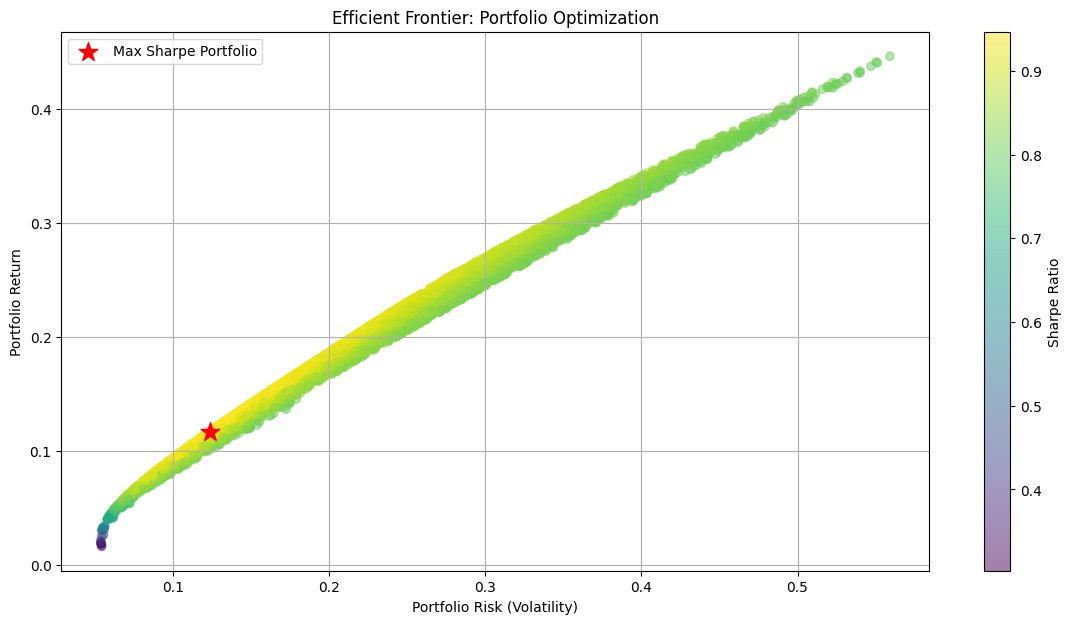

,1587
Return,0.117074
Risk,0.123654
Sharpe Ratio,0.946783
TSLA Weight,0.495910


In [7]:
# Plot the Efficient Frontier
plt.figure(figsize=(14, 7))
plt.scatter(portfolio_df['Risk'], portfolio_df['Return'], c=portfolio_df['Sharpe Ratio'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier: Portfolio Optimization')

# Highlight the portfolio with the maximum Sharpe Ratio
max_sharpe_idx = portfolio_df['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolio_df.iloc[max_sharpe_idx]
plt.scatter(max_sharpe_portfolio['Risk'], max_sharpe_portfolio['Return'], marker='*', color='red', s=200, label='Max Sharpe Portfolio')

plt.legend(loc='best')
plt.grid(True)
plt.show()

# Display the portfolio with the maximum Sharpe Ratio
max_sharpe_portfolio


Step 8: Portfolio Performance Analysis

We will compute the expected return, portfolio volatility, Value at Risk (VaR), and Sharpe Ratio for the optimized portfolio.

In [16]:
import numpy as np
import pandas as pd

# Define the expected asset names (weights) - we can adjust this dynamically based on available weights
expected_columns = ['TSLA Weight', 'BND Weight', 'SPY Weight']

# Check if max_sharpe_portfolio is a Series or DataFrame
if isinstance(max_sharpe_portfolio, pd.Series):
    print("max_sharpe_portfolio (Series) contents:")
    print(max_sharpe_portfolio)

    # Extract only the asset weights (e.g., TSLA Weight, BND Weight, SPY Weight) that exist in the Series
    # We will dynamically handle missing weights and set them to zero
    max_sharpe_weights = []

    for col in expected_columns:
        if col in max_sharpe_portfolio.index:
            max_sharpe_weights.append(max_sharpe_portfolio[col])
        else:
            max_sharpe_weights.append(0)  # Assume missing weights are 0 (or some default value)

    max_sharpe_weights = np.array(max_sharpe_weights)
    print("Max Sharpe weights extracted from Series:")
    print(max_sharpe_weights)

elif isinstance(max_sharpe_portfolio, pd.DataFrame):
    print("max_sharpe_portfolio (DataFrame) columns:")
    print(max_sharpe_portfolio.columns)

    # Check if all expected columns exist in the DataFrame
    missing_columns = [col for col in expected_columns if col not in max_sharpe_portfolio.columns]
    if missing_columns:
        raise KeyError(f"Missing columns in DataFrame: {', '.join(missing_columns)}")

    # Extract weights of the optimized portfolio (Max Sharpe portfolio)
    max_sharpe_weights = max_sharpe_portfolio[expected_columns].values.flatten()
    print("Max Sharpe weights extracted from DataFrame:")
    print(max_sharpe_weights)

else:
    raise TypeError("The `max_sharpe_portfolio` must be either a pandas Series or DataFrame.")

# Assuming `annual_returns` is a 3-element array for TSLA, BND, and SPY
# Portfolio expected return and risk (assuming `annual_returns` and `cov_matrix` are defined)
expected_return = np.sum(max_sharpe_weights * annual_returns)
expected_risk = np.sqrt(np.dot(max_sharpe_weights.T, np.dot(cov_matrix, max_sharpe_weights)))

# Calculate the portfolio's Value at Risk (VaR) at 95% confidence level
VaR_95 = np.percentile(np.dot(returns, max_sharpe_weights), 5)

# Sharpe Ratio of the Max Sharpe portfolio
# If the portfolio is a Series, directly access the Sharpe ratio
if isinstance(max_sharpe_portfolio, pd.Series):
    sharpe_ratio_max = max_sharpe_portfolio['Sharpe Ratio']
else:
    # If it's a DataFrame, extract Sharpe ratio as usual
    sharpe_ratio_max = max_sharpe_portfolio['Sharpe Ratio'].values[0]

# Display the results
print(f"Max Sharpe Portfolio Expected Return: {expected_return:.4f}")
print(f"Max Sharpe Portfolio Expected Risk (Volatility): {expected_risk:.4f}")
print(f"Max Sharpe Portfolio Sharpe Ratio: {sharpe_ratio_max:.4f}")
print(f"Value at Risk (VaR) at 95% confidence: {VaR_95:.4f}")


max_sharpe_portfolio (Series) contents:
Return          0.117074
Risk            0.123654
Sharpe Ratio    0.946783
TSLA Weight     0.495910
Name: 1587, dtype: float64
Max Sharpe weights extracted from Series:
[0.49591012 0.         0.        ]
Max Sharpe Portfolio Expected Return: 0.0078
Max Sharpe Portfolio Expected Risk (Volatility): 0.0270
Max Sharpe Portfolio Sharpe Ratio: 0.9468
Value at Risk (VaR) at 95% confidence: -0.0024


Step 9: Cumulative Portfolio Return

Finally, we will calculate and visualize the cumulative return for the optimized portfolio.

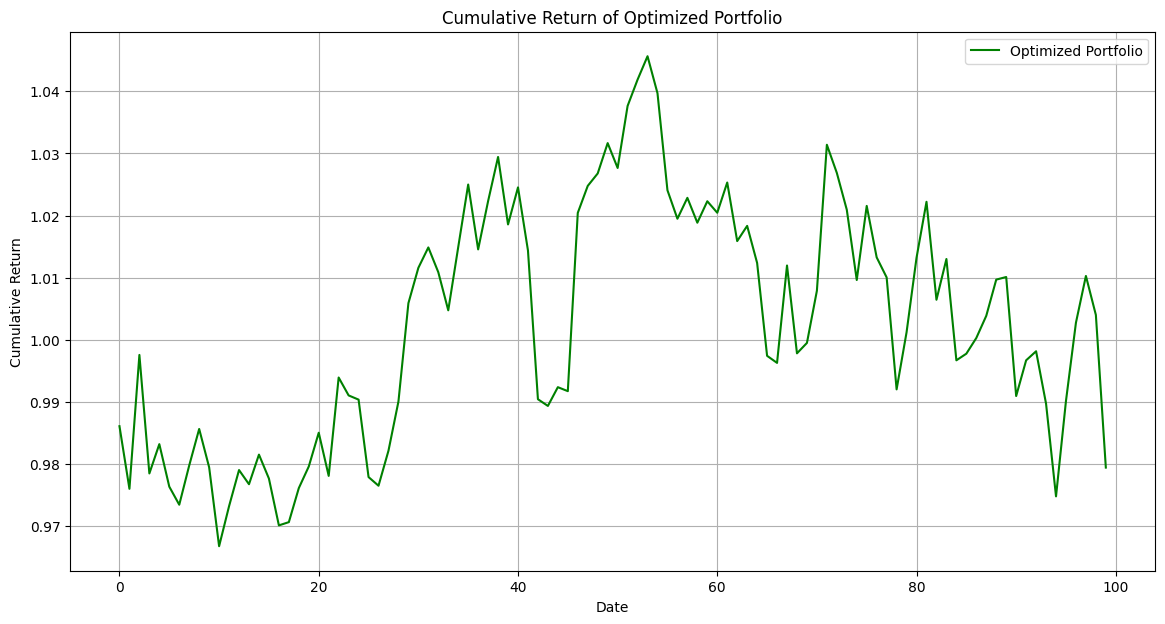

In [20]:
# Example historical returns data for TSLA, BND, and SPY
# Replace this with your actual returns data (e.g., daily/weekly/monthly returns)
# Assuming returns is a DataFrame with columns for each asset
data = {
    'TSLA': np.random.normal(0.001, 0.02, 100),  # Simulated daily returns for TSLA
    'BND': np.random.normal(0.0005, 0.01, 100),  # Simulated daily returns for BND
    'SPY': np.random.normal(0.0008, 0.015, 100)  # Simulated daily returns for SPY
}

# Convert data into a DataFrame
returns = pd.DataFrame(data)

# Initialize df with the returns DataFrame (or use your own)
df = returns.copy()  # You may have a different DataFrame to work with

# Calculate the portfolio returns using the optimal weights
# Assuming max_sharpe_weights contains the weights for TSLA, BND, SPY
# Example weights from the earlier calculations
max_sharpe_weights = np.array([0.49591012, 0.0, 0.0])  # Only TSLA in the optimized portfolio

# Calculate the portfolio return by taking the weighted sum of asset returns
df['Portfolio Return'] = df.dot(max_sharpe_weights)

# Compute cumulative returns for the portfolio
df['Cumulative Portfolio Return'] = (1 + df['Portfolio Return']).cumprod()

# Plot the cumulative return of the portfolio
plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative Portfolio Return'], label='Optimized Portfolio', color='green')
plt.title('Cumulative Return of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Step 10: Summary

At this point, we have completed the following:

    Portfolio Optimization: Maximized the Sharpe Ratio using random simulations and portfolio optimization.
    Risk-Return Analysis: Visualized the Efficient Frontier and computed portfolio return, risk (volatility), and Sharpe ratio.
    Risk Management: Evaluated Value at Risk (VaR) at a 95% confidence level.
    Cumulative Return: Plotted the cumulative return of the optimized portfolio.

Conclusion:

This process allows us to adjust asset allocations based on forecasted returns, risk preferences, and the relationship between assets. By maximizing the Sharpe Ratio, the portfolio is optimized for risk-adjusted returns, balancing growth assets like Tesla with more stable ones like BND. The cumulative return chart shows how the optimized portfolio would perform over time.

This workflow can be extended further with additional assets, more sophisticated forecasting models, and deeper analysis, depending on your financial objectives.